# Feature extraction and segmentation based on activity detection

Here we show how to configure and run MarioDetector, a short-term activity detector, and how to use the result to generate features (here just audio chunks) to feed Tensorflow models.

## Import and configure modules

In [1]:
import os
import json
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import librosa

from nsb_aad.frame_based_detectors.mario_detector import MarioDetector
from phaunos_ml.utils.feature_utils import AudioSegmentExtractor
import tensorflow as tf

# Get audio data

In [2]:
audiofilename = './data/bird.wav'
audio, sr = librosa.load(audiofilename, sr=22050)
print(audio.shape)
print(sr)

(442368,)
22050


# Configure and run activity detection

In [3]:
config_file_mario = './data/birdid_dataset/activity_detection.json'
config_mario = json.load(open(config_file_mario, 'r'))

In [4]:
config_mario

{'sample_rate': 22050,
 'win_length': 512,
 'hop_length': 128,
 'min_freq': 200,
 'max_freq': 11025,
 'clipping_threshold': 3,
 'opening_kernel_shape': [2, 3],
 'median_filter_shape': 10}

In [5]:
config_mario['clipping_threshold'] = 10
mario_detector = MarioDetector(config_mario)
mario_detections = mario_detector.process(audio)

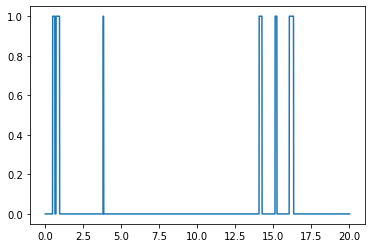

In [6]:
plt.plot(np.arange(len(mario_detections)) / mario_detector.frame_rate, mario_detections)

In [7]:
segment_duration = 2 # in seconds
segment_hop_duration = 2 # in seconds
audio_ex = AudioSegmentExtractor(
    sr=sr,
    example_duration=segment_duration,
    example_hop_duration=segment_hop_duration)

In [8]:
segments, mask_segments, stimes = audio_ex.process(
    audio,
    sr,
    mask=mario_detections,
    mask_sr=mario_detector.frame_rate,
    mask_min_dur=0.1)

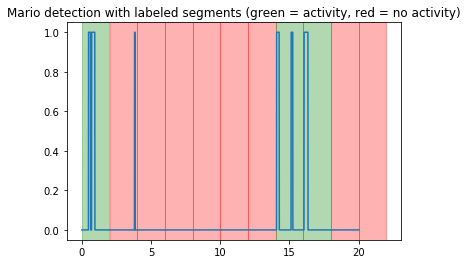

In [9]:
# plot segments (red = 0 = no audio activity detected and green = 1 = audio activity detected)
# on the detection function
fig, ax = plt.subplots()
x_axis = np.arange(len(mario_detections)) / mario_detector.frame_rate
ax.plot(x_axis, mario_detections)
ax.set_title("Mario detection with labeled segments (green = activity, red = no activity)")
for i in range(len(segments)):
    ax.axvspan(
        stimes[i][0],
        stimes[i][1],
        alpha=0.3,
        color='green' if mask_segments[i] else 'red',
        lw=1
    )

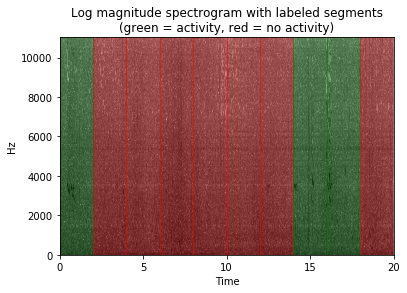

In [10]:
# compute spectrogram
spec_raw = np.abs(librosa.stft(
    audio,
    n_fft=config_mario['win_length'],
    hop_length=config_mario['hop_length'],
    center=False))

# and now plot segments on the spectrogram
plt.figure()
ax = librosa.display.specshow(
    np.log(spec_raw + 1e-6),
    sr=sr,
    hop_length=config_mario['hop_length'],
    cmap='gray_r',
    x_axis='time',
    y_axis='linear')
ax.set_title("Log magnitude spectrogram with labeled segments\n(green = activity, red = no activity)")
for i in range(len(segments)):
    ax.axvspan(
        stimes[i][0],
        stimes[i][1],
        alpha=0.3,
        color='green' if mask_segments[i] else 'red',
        lw=1
    )